In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV

from sklearn.inspection import permutation_importance

from sklearn.metrics import make_scorer, roc_auc_score
import os
%matplotlib inline

In [2]:
def score_func(y, y_pred):
    score = roc_auc_score(y, y_pred, multi_class="ovr")
    return score

my_scores = make_scorer(score_func=score_func, greater_is_better=True, needs_proba=True, needs_threshold=False)

In [3]:
os.getcwd()

'/Users/zhengyuanrui/Decoding_SALT/Decode_new/1_Script/2_model'

In [4]:
os.chdir("../../2_Data")

In [5]:
df_noref = pd.read_csv("/Users/zhengyuanrui/Decoding_SALT/Decode_new/2_Data/df_no_ref.csv")
df_selfref = pd.read_csv("/Users/zhengyuanrui/Decoding_SALT/Decode_new/2_Data/df_self_ref.csv")

In [6]:
df_noref.head()

,Subject,ExpNo,BlockNo,TrialNo,TrialNo1b,TrialNo2b,TrialNo3b,TrialNo4b,ACC,RT,...,Valence_G3b,Valence_B3b,Valence_N3b,ACC4b,RT4b,ismatch4b,Valence_G4b,Valence_B4b,Valence_N4b,label
0,1001,Exp1a,1,16,15,14,13,12,1,1065,...,1,0,0,1,865,0,1,0,0,2
1,1001,Exp1a,1,36,35,34,33,32,1,929,...,1,0,0,1,633,1,1,0,0,2
2,1001,Exp1a,1,49,48,47,46,45,0,880,...,0,1,0,1,592,1,1,0,0,1
3,1001,Exp1a,1,50,49,48,47,46,0,888,...,1,0,0,1,865,0,0,1,0,2
4,1001,Exp1a,1,51,50,49,48,47,0,777,...,1,0,0,1,648,1,1,0,0,0


In [7]:
df_selfref.head()

,Subject,ExpNo,BlockNo,TrialNo,TrialNo1b,TrialNo2b,TrialNo3b,TrialNo4b,Identity,ACC,...,Valence_G3b,Valence_B3b,Valence_N3b,ACC4b,RT4b,ismatch4b,Valence_G4b,Valence_B4b,Valence_N4b,label
0,3010,Exp3a,1,5,4,3,2,1,Self,1,...,0,1,0,1,822,1,0,0,1,1
1,3010,Exp3a,1,6,5,4,3,2,Other,1,...,0,1,0,0,660,1,0,1,0,2
2,3010,Exp3a,1,7,6,5,4,3,Self,1,...,0,0,1,0,608,1,0,1,0,0
3,3010,Exp3a,1,8,7,6,5,4,Other,0,...,0,0,1,1,747,1,0,0,1,0
4,3010,Exp3a,1,9,8,7,6,5,Self,1,...,0,1,0,1,657,0,0,0,1,0


<AxesSubplot: >

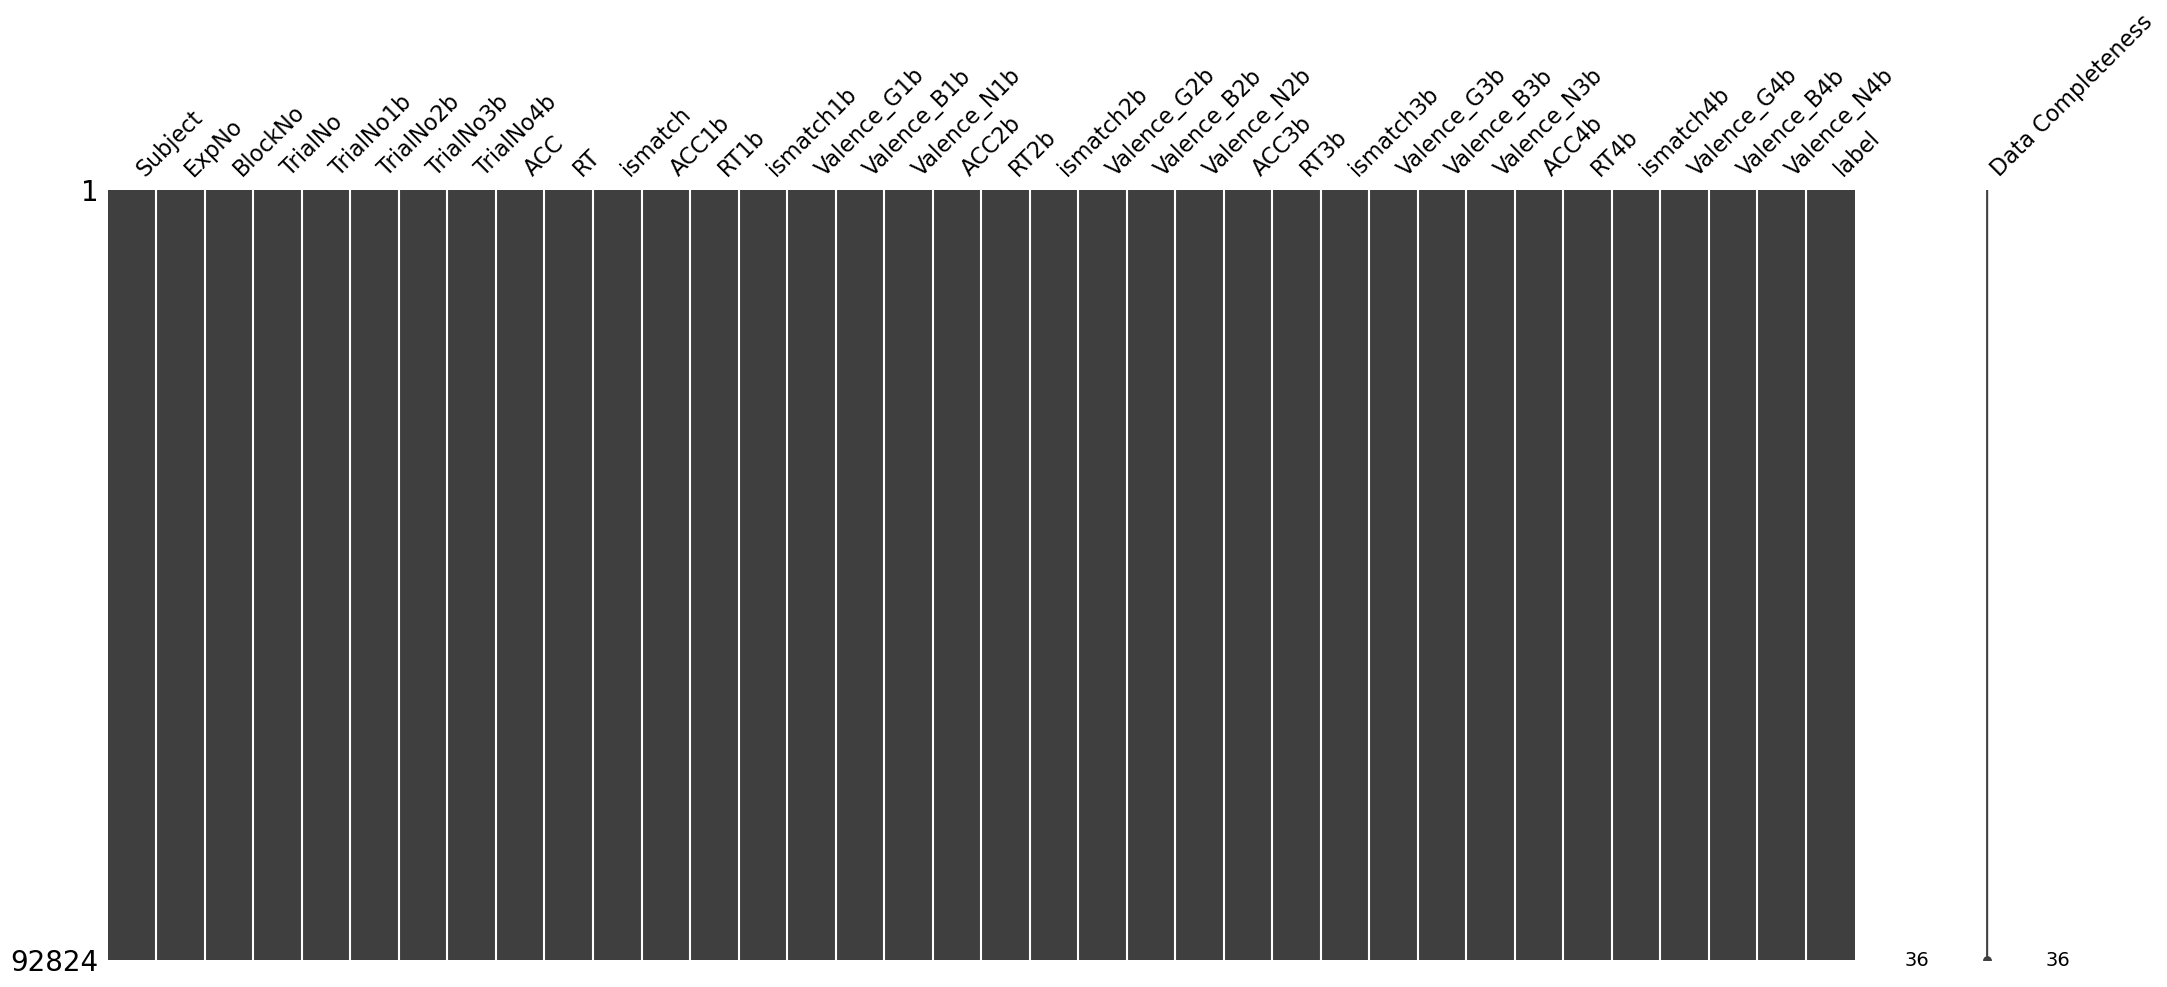

In [8]:
msno.matrix(df_noref, labels=True)

<AxesSubplot: >

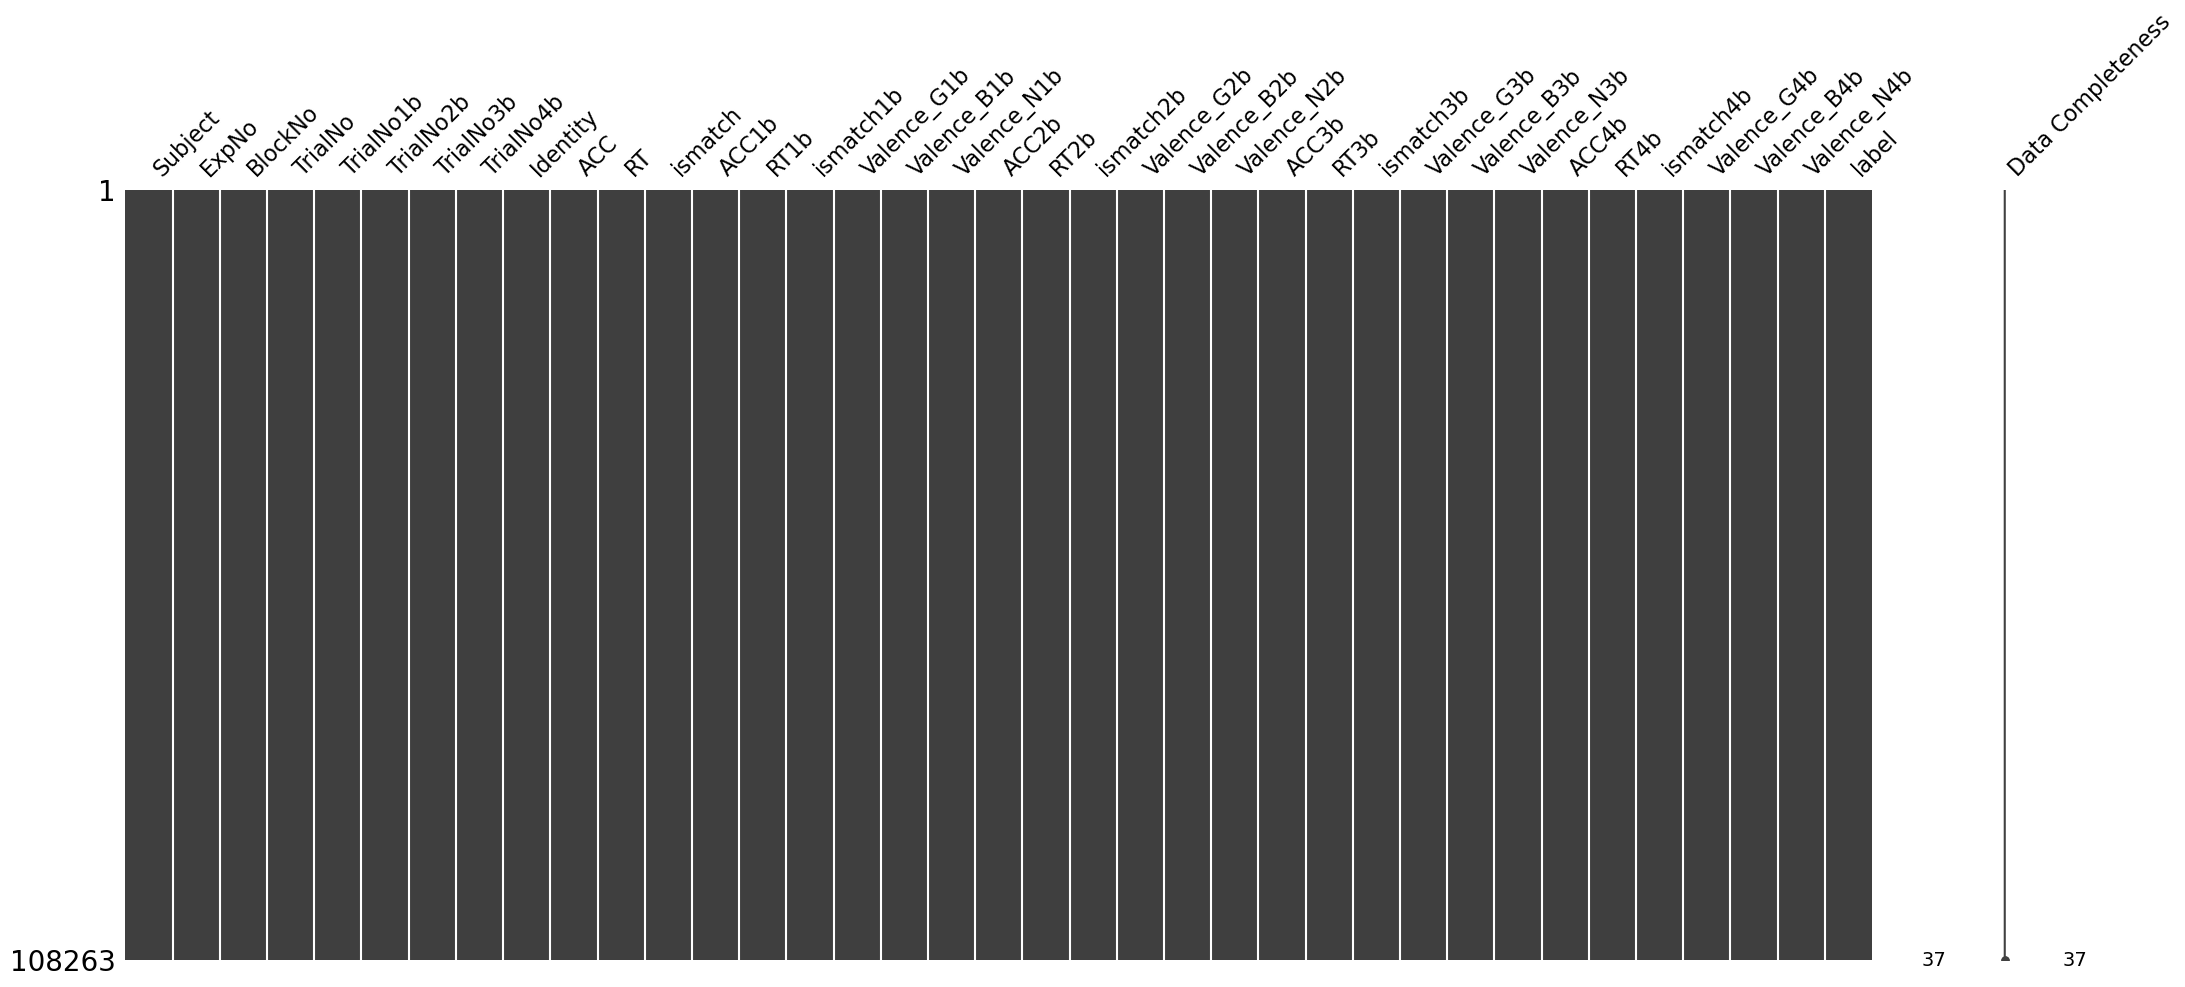

In [9]:
msno.matrix(df_selfref, labels=True)

In [10]:
X_norefc = df_noref.iloc[:, 8:11].values
X_selfrefc = df_selfref.iloc[:, 9:12].values

y_noref = df_noref["label"].values
y_selfref = df_selfref["label"].values

norefcolc = df_noref.iloc[:, 8:11].columns
selfrefcolc = df_selfref.iloc[:, 9:12].columns

In [11]:
y_noref.shape

(92824,)

In [12]:
y_selfref.shape

(108263,)

In [13]:
groups_no = df_noref["Subject"].values
groups_self = df_selfref["Subject"].values

In [14]:
logo = LeaveOneGroupOut()

In [15]:
def lr_within_task(X, y, group, source):
    df_result = dict(subID=[], score=[], source=[], target=[])# source拟合的，target预测的condition
    feature_importance = []
    for train, test in logo.split(X, y, groups=group):
        test_sub = np.unique(group[test])[0]
        df_result["subID"].append(test_sub)
        
        logi = make_pipeline(
            MinMaxScaler(), 
            LogisticRegressionCV(Cs = np.logspace(-6, 3, 7), cv = 5, class_weight='balanced', 
                                 random_state=123, max_iter=5000, multi_class="ovr"))
        
        model = logi.fit(X=X[train], y=y[train])
        im = permutation_importance(model, X[test], y[test], scoring=my_scores, n_repeats=20, n_jobs=-1, random_state=123)
        feature_importance.append(im['importances_mean'])
        y_pred = model.predict_proba(X[test])
        score = roc_auc_score(y[test], y_pred, multi_class='ovr')

        df_result['score'].append(score)
        df_result['source'].append(source)
        df_result['target'].append(source)

    return pd.DataFrame(df_result), feature_importance


In [16]:
def lr_cross_task(X_source, y_source, X_target, y_target, target_group, source_name, target_name):
    df_result = dict(subID=[], score=[], source=[], target=[])# source拟合的，target预测的condition
    feature_importance = []
    logi = make_pipeline(
            MinMaxScaler(), 
            LogisticRegressionCV(Cs = np.logspace(-6, 3, 7), cv = 5, class_weight='balanced', 
                                 random_state=123, max_iter=5000, multi_class="ovr"))

    model = logi.fit(X=X_source, y=y_source)


    for sub in np.unique(target_group):
        idx_sub = target_group == sub
        feature_sub = X_target[idx_sub]
        label_sub = y_target[idx_sub]

        im = permutation_importance(model, feature_sub, label_sub, scoring=my_scores, n_repeats=20, n_jobs=-1, random_state=123)
        feature_importance.append(im['importances_mean'])

        y_pred = model.predict_proba(feature_sub)
        score = roc_auc_score(label_sub, y_pred, multi_class="ovr")

        df_result['subID'].append(sub)
        df_result["score"].append(score)
        df_result["source"].append(source_name)
        df_result["target"].append(target_name)


    return pd.DataFrame(df_result), feature_importance

In [17]:
score_noc, im_noc = lr_within_task(X = X_norefc, y = y_noref, group = groups_no, source="No_Ref")
score_selfc, im_selfc = lr_within_task(X = X_selfrefc, y = y_selfref, group = groups_self, source="Self_Ref")

In [18]:
#No ref to self ref trial back
df_cross1c, im_cross1c = lr_cross_task(X_source=X_norefc, y_source=y_noref, X_target=X_selfrefc, y_target=y_selfref, target_group=groups_self, source_name="No_Ref", target_name="Self_Ref")
#self to no ref trial back
df_cross2c, im_cross2c = lr_cross_task(X_source=X_selfrefc, y_source=y_selfref, X_target=X_norefc, y_target=y_noref, target_group=groups_no, source_name="Self_Ref", target_name="No_Ref")

In [19]:
df_score = pd.concat([score_noc, score_selfc])

In [20]:
df_score.to_csv("LR_withinscore_current.csv")

In [21]:
df_cross_score = pd.concat([df_cross1c, df_cross2c])

In [22]:
df_cross_score.to_csv("LR_crossscore_current.csv")

In [23]:
df_im_no = pd.DataFrame(im_noc, columns=norefcolc)
df_im_no["subj_idx"] = np.arange(1, len(im_noc)+1)
df_im_no["source"] = "No_Ref"
df_im_no["target"] = "No_Ref"

df_im_self = pd.DataFrame(im_selfc, columns=selfrefcolc)
df_im_self["subj_idx"] = np.arange(1, len(im_selfc)+1)
df_im_self["source"] = "Self_Ref"
df_im_self["target"] = "Self_Ref"

In [24]:
im_no_long = pd.melt(df_im_no, id_vars=["subj_idx", "source", "target"])
im_self_long = pd.melt(df_im_self, id_vars=["subj_idx", "source", "target"])
im_within = pd.concat([im_no_long, im_self_long])
im_within

,subj_idx,source,target,variable,value
0,1,No_Ref,No_Ref,ACC,0.060046
1,2,No_Ref,No_Ref,ACC,0.031523
2,3,No_Ref,No_Ref,ACC,0.010677
3,4,No_Ref,No_Ref,ACC,-0.003473
4,5,No_Ref,No_Ref,ACC,0.019771
...,...,...,...,...,...
580,191,Self_Ref,Self_Ref,ismatch,-0.000354
581,192,Self_Ref,Self_Ref,ismatch,0.007385
582,193,Self_Ref,Self_Ref,ismatch,0.000115
583,194,Self_Ref,Self_Ref,ismatch,0.007685


In [25]:
im_within.to_csv("importance_within_current.csv")

In [26]:
df_im_cross1 = pd.DataFrame(im_cross1c, columns=selfrefcolc)
df_im_cross1["subj_idx"] = np.arange(1, len(im_cross1c)+1)
df_im_cross1["source"] = "No_Ref"
df_im_cross1["target"] = "Self_Ref"

df_im_cross2 = pd.DataFrame(im_cross2c, columns=norefcolc)
df_im_cross2["subj_idx"] = np.arange(1, len(im_cross2c)+1)
df_im_cross2["source"] = "Self_Ref"
df_im_cross2["target"] = "No_Ref"

In [27]:
im_cross1_long = pd.melt(df_im_cross1, id_vars=["subj_idx", "source", "target"])
im_cross2_long = pd.melt(df_im_cross2, id_vars=["subj_idx", "source", "target"])
im_cross = pd.concat([im_cross1_long, im_cross2_long])
im_cross

,subj_idx,source,target,variable,value
0,1,No_Ref,Self_Ref,ACC,-0.002140
1,2,No_Ref,Self_Ref,ACC,0.008618
2,3,No_Ref,Self_Ref,ACC,0.010393
3,4,No_Ref,Self_Ref,ACC,-0.004296
4,5,No_Ref,Self_Ref,ACC,0.035575
...,...,...,...,...,...
487,160,Self_Ref,No_Ref,ismatch,0.006197
488,161,Self_Ref,No_Ref,ismatch,0.011965
489,162,Self_Ref,No_Ref,ismatch,0.004133
490,163,Self_Ref,No_Ref,ismatch,-0.001995


In [28]:
im_cross.to_csv("importance_cross_current.csv")